# Stable Diffusion XL

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/adamelliotfields/notebooks/blob/main/notebooks/sdxl.ipynb)

Includes DeepCache, Compel, and Refiner.

In [1]:
# @title Install
import os
import sys
import subprocess
from importlib.util import find_spec

modules = ["compel", "DeepCache", "diffusers", "hf_transfer"]  # case sensitive
if not all(find_spec(module) for module in modules):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", *modules])
    os.kill(os.getpid(), 9)

In [2]:
# @title Imports
import gc
import os
from datetime import datetime
from hashlib import md5
from io import BytesIO
from warnings import filterwarnings

import torch
from PIL import Image
from compel import Compel, ReturnedEmbeddingsType
from compel.prompt_parser import PromptParser
from DeepCache import DeepCacheSDHelper
from diffusers import (
    DDIMScheduler,
    DPMSolverMultistepScheduler,
    DEISMultistepScheduler,
    EulerAncestralDiscreteScheduler,
    EulerDiscreteScheduler,
    PNDMScheduler,
    StableDiffusionXLPipeline,
    StableDiffusionXLImg2ImgPipeline,
    UniPCMultistepScheduler,
)
from diffusers.models import AutoencoderKL
from transformers import logging

In [3]:
# @title Environment
try:
    from google.colab import userdata

    HF_TOKEN = userdata.get("HF_TOKEN")
except ImportError:
    HF_TOKEN = os.environ.get("_HF_TOKEN", None) or os.environ.get("HF_TOKEN", "")
finally:
    os.environ["HF_TOKEN"] = HF_TOKEN
    os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1"

filterwarnings("ignore", category=FutureWarning, module="diffusers")
filterwarnings("ignore", category=FutureWarning, module="transformers")
logging.set_verbosity_error()

In [4]:
class Loader:
    _instance = None

    def __new__(cls):
        if cls._instance is None:
            cls._instance = super().__new__(cls)
            cls._instance.pipe = None
            cls._instance.model = None
            cls._instance.refiner = None
        return cls._instance

    def _flush(self):
        gc.collect()
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
        torch.cuda.reset_peak_memory_stats()
        torch.cuda.synchronize()

    def _load_pipeline(self, model, cpu_offload, **kwargs):
        if self.pipe is None:
            print(f"Loading {model}...")
            self.model = model
            self.pipe = StableDiffusionXLPipeline.from_pretrained(model, **kwargs)
            if cpu_offload:
                self.pipe.enable_model_cpu_offload()
            else:
                self.pipe.to("cuda")

    def _load_refiner(self, refiner_model, use_refiner, cpu_offload, **kwargs):
        if self.refiner is None and use_refiner:
            print(f"Loading {refiner_model}...")
            self.refiner = StableDiffusionXLImg2ImgPipeline.from_pretrained(refiner_model, **kwargs)
            if cpu_offload:
                self.refiner.enable_model_cpu_offload()
            else:
                self.refiner.to("cuda")

    def _load_deepcache(self, interval=1):
        has_deepcache = hasattr(self.pipe, "deepcache")
        if has_deepcache and self.pipe.deepcache.params["cache_interval"] == interval:
            return
        if has_deepcache:
            self.pipe.deepcache.disable()
        else:
            self.pipe.deepcache = DeepCacheSDHelper(pipe=self.pipe)
        self.pipe.deepcache.set_params(cache_interval=interval)
        self.pipe.deepcache.enable()

    def _should_unload_refiner(self, model, refiner):
        if self.refiner is None:
            return False
        if self.model.lower() != model.lower():
            return True
        if not refiner:
            return True
        return False

    def _should_unload_pipeline(self, model):
        if self.pipe is None:
            return False
        if self.model.lower() != model.lower():
            return True
        return False

    def _unload(self, model, refiner):
        items = []
        if self._should_unload_refiner(model, refiner):
            items.append("refiner")
        if self._should_unload_pipeline(model):
            items.append("pipe")
            items.append("model")
        for item in items:
            delattr(self, items)
        self._flush()
        for item in items:
            setattr(self, item, None)

    def load(self, model, scheduler, karras, deepcache, refiner, cpu_offload):
        vae_model = "madebyollin/sdxl-vae-fp16-fix"
        refiner_model = "stabilityai/stable-diffusion-xl-refiner-1.0"

        schedulers = {
            "DDIM": DDIMScheduler,
            "DEIS 2M": DEISMultistepScheduler,
            "DPM++ 2M": DPMSolverMultistepScheduler,
            "Euler": EulerDiscreteScheduler,
            "Euler a": EulerAncestralDiscreteScheduler,
            "UniPC 2M": UniPCMultistepScheduler,
        }
        scheduler_kwargs = {
            "beta_start": 0.00085,
            "beta_end": 0.012,
            "beta_schedule": "scaled_linear",
            "timestep_spacing": "leading",
            "steps_offset": 1,
        }

        if scheduler not in ["DDIM", "Euler a"]:
            scheduler_kwargs["use_karras_sigmas"] = karras

        # https://github.com/huggingface/diffusers/blob/8a3f0c1/scripts/convert_original_stable_diffusion_to_diffusers.py#L939
        if scheduler == "DDIM":
            scheduler_kwargs["clip_sample"] = False
            scheduler_kwargs["set_alpha_to_one"] = False

        # no fp16 variant (already half-precision)
        if model.lower() not in ["cagliostrolab/animagine-xl-3.1", "fluently/fluently-xl-final"]:
            variant = "fp16"
        else:
            variant = None

        dtype = torch.float16
        pipe_kwargs = {
            "variant": variant,
            "torch_dtype": dtype,
            "add_watermarker": False,
            "scheduler": schedulers[scheduler](**scheduler_kwargs),
            "vae": AutoencoderKL.from_pretrained(vae_model, torch_dtype=dtype),
        }

        self._unload(model, refiner)
        self._load_pipeline(model, cpu_offload, **pipe_kwargs)

        # error
        if self.pipe is None:
            return

        same_scheduler = isinstance(self.pipe.scheduler, schedulers[scheduler])
        same_karras = (
            not hasattr(self.pipe.scheduler.config, "use_karras_sigmas")
            or self.pipe.scheduler.config.use_karras_sigmas == karras
        )

        if self.model.lower() == model.lower():
            if not same_scheduler:
                print(f"Switching to {scheduler}...")
            if not same_karras:
                print(f"{'Enabling' if karras else 'Disabling'} Karras sigmas...")
            if not same_scheduler or not same_karras:
                self.pipe.scheduler = schedulers[scheduler](**scheduler_kwargs)

        refiner_kwargs = {
            "variant": "fp16",
            "torch_dtype": dtype,
            "add_watermarker": False,
            "requires_aesthetics_score": True,
            "force_zeros_for_empty_prompt": False,
            "vae": self.pipe.vae,
            "scheduler": self.pipe.scheduler,
            "tokenizer_2": self.pipe.tokenizer_2,
            "text_encoder_2": self.pipe.text_encoder_2,
        }

        self._load_refiner(refiner_model, refiner, cpu_offload, **refiner_kwargs)
        self._load_deepcache(deepcache)

In [5]:
# @title Inference
def main():
    global \
        MODEL, \
        SCHEDULER, \
        PROMPT, \
        NEGATIVE_PROMPT, \
        SEED, \
        OUT_DIR, \
        WIDTH, \
        HEIGHT, \
        GUIDANCE_SCALE, \
        INFERENCE_STEPS, \
        DEEPCACHE, \
        KARRAS, \
        REFINER, \
        CPU_OFFLOAD

    if not torch.cuda.is_available():
        raise RuntimeError("CUDA not available")

    if SEED is None or SEED < 0:
        seed = int(datetime.now().timestamp() * 1e6) % (2**64)
    else:
        seed = SEED

    loader = Loader()
    loader.load(MODEL, SCHEDULER, KARRAS, DEEPCACHE, REFINER, CPU_OFFLOAD)

    if loader.pipe is None:
        raise RuntimeError(f"Error loading {MODEL}")

    pipe = loader.pipe
    refiner = loader.refiner

    # prompt embeddings for base and refiner
    embeddings_type = ReturnedEmbeddingsType.PENULTIMATE_HIDDEN_STATES_NON_NORMALIZED
    compel_1 = Compel(
        text_encoder=[pipe.text_encoder, pipe.text_encoder_2],
        tokenizer=[pipe.tokenizer, pipe.tokenizer_2],
        requires_pooled=[False, True],
        returned_embeddings_type=embeddings_type,
        dtype_for_device_getter=lambda _: pipe.dtype,
        device=pipe.device,
    )
    compel_2 = Compel(
        text_encoder=[pipe.text_encoder_2],
        tokenizer=[pipe.tokenizer_2],
        requires_pooled=[True],
        returned_embeddings_type=embeddings_type,
        dtype_for_device_getter=lambda _: pipe.dtype,
        device=pipe.device,
    )
    generator = torch.Generator(device=pipe.device).manual_seed(seed)

    try:
        conditioning_1, pooled_1 = compel_1([PROMPT, NEGATIVE_PROMPT])
        conditioning_2, pooled_2 = compel_2([PROMPT, NEGATIVE_PROMPT])
    except PromptParser.ParsingException:
        raise RuntimeError("Error parsing prompt")

    pipe_output_type = "pil"
    refiner_output_type = "pil"
    if REFINER:
        pipe_output_type = "latent"

    pipe_kwargs = {
        "width": WIDTH,
        "height": HEIGHT,
        "denoising_end": 0.8 if REFINER else None,
        "generator": generator,
        "output_type": pipe_output_type,
        "guidance_scale": GUIDANCE_SCALE,
        "num_inference_steps": INFERENCE_STEPS,
        "prompt_embeds": conditioning_1[0:1],
        "pooled_prompt_embeds": pooled_1[0:1],
        "negative_prompt_embeds": conditioning_1[1:2],
        "negative_pooled_prompt_embeds": pooled_1[1:2],
    }

    try:
        image = pipe(**pipe_kwargs).images[0]
        refiner_kwargs = {
            "image": image,
            "denoising_start": 0.8,
            "generator": generator,
            "output_type": refiner_output_type,
            "guidance_scale": GUIDANCE_SCALE,
            "num_inference_steps": INFERENCE_STEPS,
            "prompt_embeds": conditioning_2[0:1],
            "pooled_prompt_embeds": pooled_2[0:1],
            "negative_prompt_embeds": conditioning_2[1:2],
            "negative_pooled_prompt_embeds": pooled_2[1:2],
        }
        if REFINER:
            image = refiner(**refiner_kwargs).images[0]
    except Exception as e:
        raise RuntimeError(f"Error generating image: {e}")

    image_file = save_image(image, OUT_DIR)
    print(image_file)
    display(Image.open(image_file))


def save_image(image, out_dir="."):
    image_bytes = BytesIO()
    image.save(image_bytes, format="PNG")
    image_bytes.seek(0)
    image_hash = md5(image_bytes.read()).hexdigest()
    filename = f"{out_dir}/{image_hash}.png"
    image.save(filename)
    return filename

  0%|          | 0/35 [00:00<?, ?it/s]

./d096bb0f4b4e985469c15d04895f4aa5.png


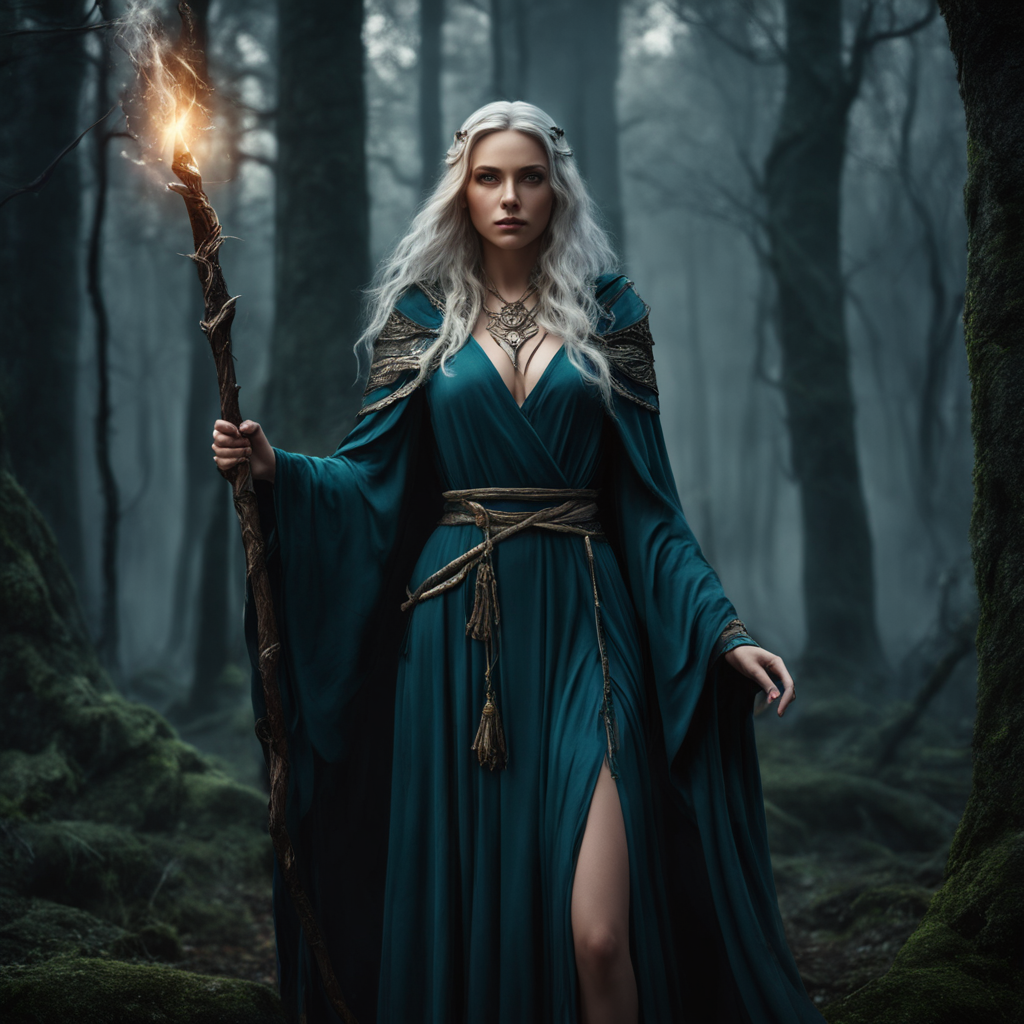

In [6]:
# fmt: off
PROMPT = "powerful sorceress, flowing robes and mystical staff, standing in dark and ominous forest, fantasy portrait, mysterious, high detail, realistic, 8k"  # @param {type: "string"}
NEGATIVE_PROMPT = "ugly, unattractive, (disfigured, deformed, mutated, malformed)1.1, blurry, grainy, noisy, oversaturated, undersaturated, overexposed, underexposed, worst quality, low details, lowres, watermark, signature, autograph, trademark, sloppy, cluttered"  # @param {type: "string"}
MODEL = "fluently/Fluently-XL-Final"  # @param {type: "string"}
SCHEDULER = "Euler"  # @param {type: "string"} ["DDIM", "DEIS 2M", "DPM++ 2M", "Euler", "Euler a", "PNDM"]
SEED = 2012602637999660  # @param {type: "integer", min: -1, max: 18446744073709551615}
OUT_DIR = "."  # @param {type: "string"}
WIDTH = 1024  # @param {type: "slider", min: 512, max: 1536, step: 64}
HEIGHT = 1024  # @param {type: "slider", min: 512, max: 1536, step: 64}
GUIDANCE_SCALE = 5  # @param {type: "slider", min: 0, max: 15, step: 0.1}
INFERENCE_STEPS = 36  # @param {type: "slider", min: 1, max: 50}
DEEPCACHE = 1  # @param {type: "slider", min: 1, max: 4}
KARRAS = True  # @param {type: "boolean"}
REFINER = True  # @param {type: "boolean"}
CPU_OFFLOAD = False  # @param {type: "boolean"}
main()